# What is torch.nn ?

## MNIST data setup

We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use pathlib for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/master/_static/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

In [2]:
import pickle
import gzip 

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.


(50000, 784)


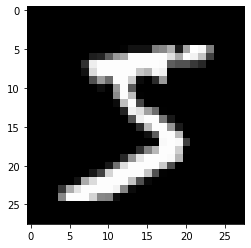

In [3]:
from matplotlib import pyplot
import numpy as np

print(x_train.shape)
pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape

x_train, x_train.shape, y_train.min(), y_train.max()

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## neural net from scratch (no torch.nn)

Let’s first create a model using nothing but PyTorch tensor operations. We’re assuming you’re already familiar with the basics of neural networks. (If you’re not, you can learn them at [course.fast.ai](https://course.fast.ai/)).

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation _automatically_!

For the weights, we set `requires_grad` **after** the initialization, since we don’t want that step included in the gradient. (Note that a trailing `_` in PyTorch signifies that the operation is performed in-place.)

We are initializing the weights here with [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (by multiplying with 1/sqrt(n)).

In [5]:
import math

# 10 neurons in the output layer
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # set requires_grad in-place 
bias = torch.zeros(10, requires_grad=True) 

In [6]:
print(weights.shape, bias.shape)

torch.Size([784, 10]) torch.Size([10])


Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! 

So let’s just write a plain **matrix multiplication** and **broadcasted addition** to create a simple **linear model**. 

We also need an **activation function**, so we’ll write _log_softmax_ and use it. 

Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax( xb @ weights + bias )

In the above, the `@` stands for the **dot product** operation. 

We will call our function on **one batch** of data (in this case, 64 images). 

This is one $\color{yellow}{\textbf{foward}}$ pass. 

Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [8]:
bs = 64 # batch size

xb = x_train[0 : bs] # one mini-batch from x
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.3681, -2.4970, -2.5899, -1.9262, -2.0757, -2.3267, -2.2474, -1.9873,
        -2.5858, -2.7785], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement **negative log-likelihood** to use as the **loss function** (again, we can just use standard Python):

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3301, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the **accuracy** of our model. 

For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [12]:
print(accuracy(preds, yb))

tensor(0.1562)


We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- loss.backward() updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations [here](https://pytorch.org/docs/stable/notes/autograd.html).

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` **_adds_** the gradients to whatever is already stored, rather than replacing them).

You can use the standard python debugger to step through PyTorch code, allowing you to check the various variable values at each step. Uncomment `set_trace()` below to try it out.

In [14]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range( (n-1) // bs + 1 ):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [15]:
print( 
    loss_func(model(xb), yb), 
    accuracy(model(xb), yb) 
)

tensor(0.0827, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s `nn` classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: **shorter, more understandable, and/or more flexible**.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from `torch.nn.functional` (which is generally imported into the namespace `F` by convention). This module contains all the **functions** in the `torch.nn` library (whereas other parts of the library contain **classes**). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function `F.cross_entropy` that combines the two. So we can even remove the activation function from our model.

In [16]:
import torch.nn.functional as F 

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call `log_softmax` in the model function. 

Let’s confirm that our loss and accuracy are the same as before:

In [17]:
print( 
    loss_func(model(xb), yb), 
    accuracy(model(xb), yb) 
)

tensor(0.0827, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

Next up, we’ll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop. 

We subclass `nn.Module` (which itself is a class and able to keep track of state). 

In this case, we want to create a class that holds our weights, bias, and method for the forward step. 

`nn.Module` has a number of **attributes** and **methods** (such as `.parameters()` and `.zero_grad()`) which we will be using.

In [18]:
from torch import nn 

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter( torch.randn(784, 10) / math.sqrt(784) )
        self.bias = nn.Parameter( torch.zeros(10) )
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

Since we’re now using an **object** instead of just using a function, we first have to **instantiate** our model:

In [19]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. 

Note that `nn.Module` objects are used as if they are **functions** (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [20]:
print(loss_func(model(xb), yb))

tensor(2.2570, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:

```
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

Now we can take advantage of `model.parameters()` and `model.zero_grad()` (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:

In [ ]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

We’ll wrap our little training loop in a fit function so we can run it again later.

In [23]:
def fit():
    for epoch in range(epochs):
        for i in range( (n-1) // bs + 1 ):
            # set_trace()
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i : end_i]
            yb = y_train[start_i : end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters(): 
                    p -= p.grad * lr
                model.zero_grad()

In [24]:
fit()

Let’s double-check that our loss has gone down:

In [25]:
print(loss_func(model(xb), yb))

tensor(0.0810, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

We continue to refactor our code. 

Instead of manually defining and initializing `self.weights` and `self.bias`, and calculating `xb  @ self.weights + self.bias`, we will instead use the Pytorch class `nn.Linear` for a **linear** layer, which does all that for us. 

Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [28]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:

In [29]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3793, grad_fn=<NllLossBackward>)


We are still able to use our same fit method as before.

In [30]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


## Refactor using optim

Pytorch also has a package with various optimization algorithms, `torch.optim`. 

We can use the `step` method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```
opt.step()
opt.zero_grad()
```

`optim.zero_grad()` resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch. 

We’ll define a little function to create our model and optimizer so we can reuse it in the future.

In [33]:
from torch import optim 

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print('before training:', loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range( (n-1) // bs + 1 ):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        opt.step()
        opt.zero_grad()

print('after training:', loss_func(model(xb), yb))    

before training: tensor(2.2926, grad_fn=<NllLossBackward>)
after training: tensor(0.0807, grad_fn=<NllLossBackward>)


## Refactor using Dataset

PyTorch has an abstract `Dataset` class. A Dataset can be anything that has a `__len__` function (called by Python’s standard len function) and a `__getitem__` function as a way of indexing into it. 

This tutorial walks through a nice example of creating a custom `FacialLandmarkDataset` class as a subclass of `Dataset`.

PyTorch’s `TensorDataset` is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the **independent** and **dependent** variables in the same line as we train.